# __Original notebook can be found here:__ https://www.kaggle.com/code/nandinitatiwala/traffic-sign-transfer-learning-classification

# Introduction
With automation becoming increasingly common, machine models being able understand traffic signs is key for self-driving cars and other forms of transport to ensure safety. As such, I wanted to incorporate deep learning into this and see how a machine learning model would respond to identifying various traffic signs.

The goal of this investigation is to see if, using a pertained model, I could get a model that is able to accurately classify traffic signs.

## Setting Up
First, we need to set up the general base for a machine learning model. 

In [1]:
# loading general packages and libraries 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import cv2
import random
from PIL import Image

# loading tensor flow libraries needed
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Dropout, Flatten, MaxPool2D,BatchNormalization
from keras.preprocessing import image
from tensorflow.keras.optimizers import Adam,SGD
import keras
from keras.preprocessing import image

seed=1
np.random.seed(seed)
tf.random.set_seed(seed)

2024-03-11 15:54:20.784320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 15:54:20.784454: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 15:54:21.072771: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Gather and Explore the Data
For this investigation, I will be using a dataset I found on Kaggle. The data consists of images of traffic signs which have been automatically registered so that the sign is centred and occupies around the same space in each image.

The are around 58 classes and each class has around 120 images. Since this dataset has not been cleaned and organised completely, we first need to ensure there is an adequete amount of photos in each class and that they are correctly categorised.

In [2]:
# importing images
train_dir = "/kaggle/input/traffic-sign-dataset-classification/traffic_Data/DATA/" 

# reading the csv file
labels = pd.read_csv("/kaggle/input/traffic-sign-dataset-classification/labels.csv")
labels

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)
5,5,Speed limit (60km/h)
6,6,Speed limit (70km/h)
7,7,speed limit (80km/h)
8,8,Dont Go straight or left
9,9,Dont Go straight or Right


In [3]:
# no. of images per label
lst = []
for i in labels.index:
    lst.append(len(os.listdir(train_dir + str(i))))
labels['count'] = lst
labels['count'].describe()

count     58.000000
mean      71.896552
std       83.818034
min        2.000000
25%       18.000000
50%       38.000000
75%      107.500000
max      446.000000
Name: count, dtype: float64

In [4]:
# only keep those with enough images in each label 
labels = labels[labels['count'] >= 107.5]
labels

,ClassId,Name,count
0,0,Speed limit (5km/h),118
3,3,Speed limit (40km/h),260
5,5,Speed limit (60km/h),194
7,7,speed limit (80km/h),152
11,11,Dont Go Left,138
14,14,Dont overtake from Left,128
16,16,No Car,142
17,17,No horn,130
26,26,keep Right,126
28,28,watch out for cars,446


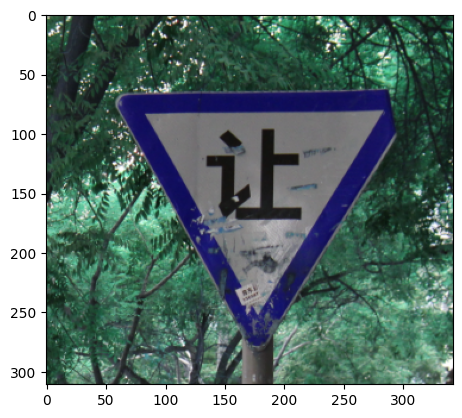

In [5]:
# finding the unknown image
fnames = os.listdir(train_dir + '56')
img = cv2.imread(train_dir + '56/' + fnames[3])
plt.imshow(img)

In [6]:
# renaming
labels.loc[56, "Name"] = "Yield"

labels["Name"] = ["Speed Limit 5", "Speed Limit 40",
       "Speed Limit 60", "Speed Limit 80", "No Left",
       "No Overtake from Left", "No Cars", "No Horn", "Keep Right",
       "Watch for Cars", "Bicycle Crossing", "Zebra Crossing",
       "No Stopping", "No Entry", "Yield"]

/tmp/ipykernel_26/733333294.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labels["Name"] = ["Speed Limit 5", "Speed Limit 40",


Now that we have cleaned the data, we can load the libraries.

In [7]:
# set the image size 
image_size = 128

# input and data augmentation
train_datagen = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,                                       
        fill_mode="nearest",
        validation_split=0.25,
    )

train_generator = train_datagen.flow_from_directory(
    directory = train_dir,          
    target_size = (image_size, image_size), 
    batch_size = 28,
    shuffle=True,
    class_mode = "categorical",   
    subset = "training"     
)

validation_generator = train_datagen.flow_from_directory(
    directory = train_dir,   
    target_size = (image_size, image_size),   
    batch_size = 28, 
    class_mode = "categorical",
    subset = "validation"
)

Found 3144 images belonging to 58 classes.
Found 1026 images belonging to 58 classes.


## Transfer Learning

Since the data is ready, it is time to train the model using the pretrained ResNet50 model. This is already done through transfer learning, which takes a pretrained model, removes the final layer, and replaces that last layer with the relevant output.

ResNet50 is quite a popular model and accurate for this project since it is commonly used for traffic sign analysis.

Below, is the first model (removing the final layer of the ResNet50 model and replacing it with a Dense final layer with the number of nodes being the number of outputs).

### Model 1

In [8]:
# set classes to number of categories and input weight paths
num_classes = 58
resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

# defining the model
model = Sequential()
model.trainable = True

model.add(ResNet50(include_top=False, pooling='avg', weights= resnet_weights_path))
model.add(BatchNormalization())
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Now, we need to compile the final layer of the network using categorical_crossentropy as the loss function and the stochastic gradient descent (as the optimizer) to minimize the categorical cross-entropy loss. 

In [9]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

Now we fit the model for training and validation using 12 epochs and 60 steps per epoch.

In [10]:
history = model.fit(
        train_generator,
        steps_per_epoch= 60,
        epochs = 12,
        validation_data=validation_generator,
        validation_steps=5)

Epoch 1/12


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/60 ━━━━━━━━━━━━━━━━━━━━ 43:29 44s/step - accuracy: 0.0000e+00 - loss: 4.1371

I0000 00:00:1710172528.620729      93 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710172528.693876      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


31/60 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.0546 - loss: 3.9831

W0000 00:00:1710172561.473679      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 743ms/step - accuracy: 0.1246 - loss: 3.7589

W0000 00:00:1710172577.659930      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 849ms/step - accuracy: 0.1268 - loss: 3.7523 - val_accuracy: 0.0000e+00 - val_loss: 4.0423
Epoch 2/12
53/60 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.4956 - loss: 2.6119

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 217ms/step - accuracy: 0.5012 - loss: 2.5960 - val_accuracy: 0.0143 - val_loss: 4.0449
Epoch 3/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 16s 237ms/step - accuracy: 0.6566 - loss: 2.0942 - val_accuracy: 0.0643 - val_loss: 3.9227
Epoch 4/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.7097 - loss: 1.7188 - val_accuracy: 0.0786 - val_loss: 3.8691
Epoch 5/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 205ms/step - accuracy: 0.7460 - loss: 1.4982 - val_accuracy: 0.0429 - val_loss: 3.9235
Epoch 6/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.7774 - loss: 1.3368 - val_accuracy: 0.0357 - val_loss: 3.9676
Epoch 7/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.7898 - loss: 1.1872 - val_accuracy: 0.0786 - val_loss: 3.9890
Epoch 8/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.8263 - loss: 1.0238 - val_accuracy: 0.0000e+00 - val_loss: 4.1249
Epoch 9/12


W0000 00:00:1710172666.946222      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.8502 - loss: 0.9415 - val_accuracy: 0.1143 - val_loss: 3.8336
Epoch 10/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.8572 - loss: 0.8670 - val_accuracy: 0.1357 - val_loss: 3.7268
Epoch 11/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 178ms/step - accuracy: 0.8522 - loss: 0.8374 - val_accuracy: 0.3571 - val_loss: 2.9649
Epoch 12/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.8848 - loss: 0.7143 - val_accuracy: 0.5143 - val_loss: 2.3493


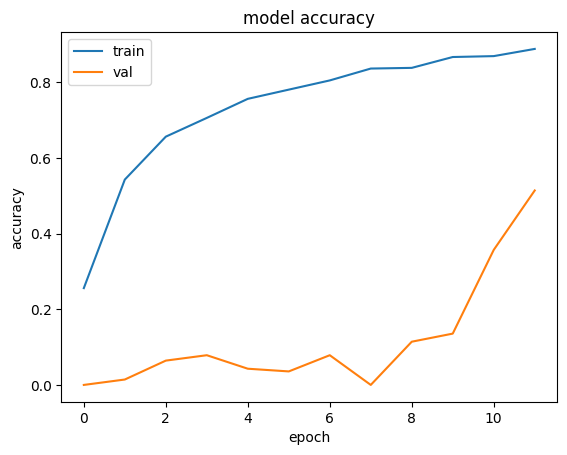

In [11]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

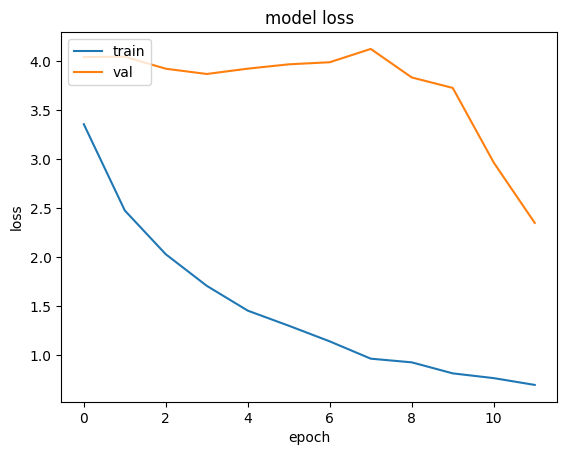

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

This wasn't bad at all for a first model! We got a accuracy score of 88% and a validation accuracy of 52%. Let's see if it can be improved with a different optimiser called adam and changing a few parameters.

### Model 2

In [13]:
# define the model (add layers)
model2 = Sequential()
model2.trainable = True

model2.add(ResNet50(include_top=False, pooling='avg', weights= resnet_weights_path))
model2.add(BatchNormalization())
model2.add(Dense(48, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(128, activation='relu'))
model2.add(Dense(num_classes, activation='softmax'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [14]:
model2.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
history2 = model2.fit(
        train_generator,
        steps_per_epoch= 60,
        epochs = 12,
        validation_data=validation_generator,
        validation_steps=5)

Epoch 1/12
 1/60 ━━━━━━━━━━━━━━━━━━━━ 59:11 60s/step - accuracy: 0.0000e+00 - loss: 4.3901

W0000 00:00:1710172774.212604      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/60 ━━━━━━━━━━━━━━━━━━━━ 26:23 27s/step - accuracy: 0.0000e+00 - loss: 4.3513

W0000 00:00:1710172801.463471      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.3012 - loss: 3.1742

W0000 00:00:1710172816.729791      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 103s 733ms/step - accuracy: 0.3040 - loss: 3.1618 - val_accuracy: 0.0714 - val_loss: 3.9114
Epoch 2/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 163ms/step - accuracy: 0.6645 - loss: 1.4237 - val_accuracy: 0.0714 - val_loss: 3.7693
Epoch 3/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step - accuracy: 0.7652 - loss: 0.9614 - val_accuracy: 0.1000 - val_loss: 4.1421
Epoch 4/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 0.7863 - loss: 0.8261 - val_accuracy: 0.0143 - val_loss: 4.1909
Epoch 5/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.8484 - loss: 0.5489 - val_accuracy: 0.0000e+00 - val_loss: 4.5445
Epoch 6/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.8872 - loss: 0.3861 - val_accuracy: 0.0071 - val_loss: 4.3466
Epoch 7/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 0.9118 - loss: 0.3289 - val_accuracy: 0.0000e+00 - val_loss: 8.6772
Epoch 8/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.8663 - loss: 0.4509 - val_accuracy

W0000 00:00:1710172892.620914      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.8727 - loss: 0.5293 - val_accuracy: 0.0714 - val_loss: 6.0716
Epoch 10/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.8762 - loss: 0.4240 - val_accuracy: 0.1357 - val_loss: 7.5043
Epoch 11/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.9347 - loss: 0.2367 - val_accuracy: 0.1643 - val_loss: 5.4562
Epoch 12/12
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.9193 - loss: 0.2759 - val_accuracy: 0.2786 - val_loss: 3.9369


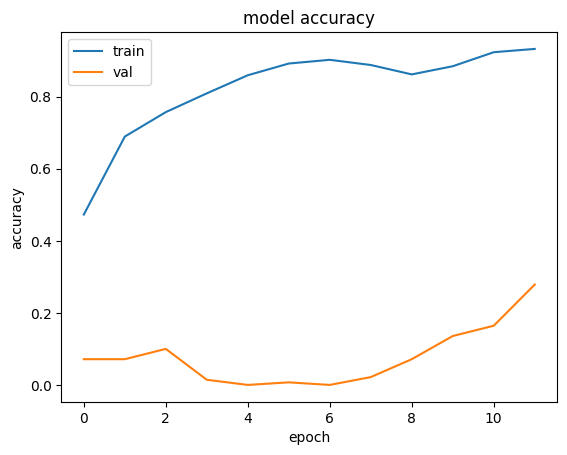

In [16]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

This model is slightly better! With an accuracy score of 89%, this was improved however the validation accuracy was only 10%. Using this as the base, lets tune the parameters to see if we can improve the validation accuracy score.

### Model 3

In [17]:
# define the model
model3 = Sequential()
model3.trainable = True

model3.add(ResNet50(include_top=False, pooling='avg', weights= resnet_weights_path))
model3.add(BatchNormalization())
model3.add(Dense(48, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(128, activation='relu'))
model3.add(Dense(num_classes, activation='softmax'))

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [18]:
model3.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# tuning to try to improve the score
history3 = model3.fit(
        train_generator,
        steps_per_epoch= 60,
        epochs = 15,
        validation_data=validation_generator,
        validation_steps=7)

Epoch 1/15
 1/60 ━━━━━━━━━━━━━━━━━━━━ 58:34 60s/step - accuracy: 0.0000e+00 - loss: 4.2561

W0000 00:00:1710173000.081032      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.2940 - loss: 3.1609

W0000 00:00:1710173014.831014      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 264ms/step - accuracy: 0.2963 - loss: 3.1499 - val_accuracy: 0.1122 - val_loss: 26.0758
Epoch 2/15
18/60 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6512 - loss: 1.4993 

W0000 00:00:1710173039.138016      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 30s 501ms/step - accuracy: 0.6648 - loss: 1.4168 - val_accuracy: 0.0357 - val_loss: 8.4326
Epoch 3/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - accuracy: 0.7455 - loss: 0.9719 - val_accuracy: 0.0051 - val_loss: 4.2894
Epoch 4/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.7723 - loss: 0.8509 - val_accuracy: 0.0153 - val_loss: 4.3103
Epoch 5/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step - accuracy: 0.7780 - loss: 0.8527 - val_accuracy: 0.0153 - val_loss: 4.4693
Epoch 6/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.8208 - loss: 0.5962 - val_accuracy: 0.0435 - val_loss: 6.2045
Epoch 7/15


W0000 00:00:1710173090.281853      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.8661 - loss: 0.4977 - val_accuracy: 0.0102 - val_loss: 6.7922
Epoch 8/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 10s 162ms/step - accuracy: 0.8829 - loss: 0.3841 - val_accuracy: 0.0153 - val_loss: 9.3577
Epoch 9/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 0.8959 - loss: 0.3400 - val_accuracy: 0.0051 - val_loss: 10.8075
Epoch 10/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.8582 - loss: 0.4715 - val_accuracy: 0.0357 - val_loss: 9.4032
Epoch 11/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.9136 - loss: 0.2878 - val_accuracy: 0.2245 - val_loss: 4.1916
Epoch 12/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.9025 - loss: 0.3427 - val_accuracy: 0.1087 - val_loss: 4.9673
Epoch 13/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 206ms/step - accuracy: 0.9314 - loss: 0.2633 - val_accuracy: 0.3265 - val_loss: 3.9551
Epoch 14/15
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 159ms/step - accuracy: 0.9361 - loss: 0.1991 - val_accuracy: 0.

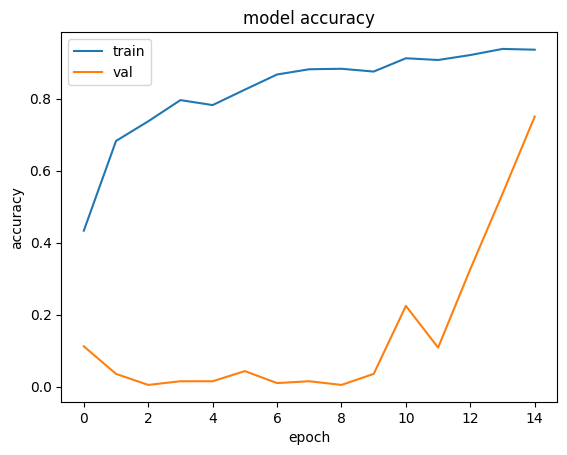

In [20]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

This was much better! It seems Model 3 resulted in the best scores with an accuracy score of 92% and a validation score of 68%.

## Prediction
Let's use an image from the testing data to see the accuracy of the model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


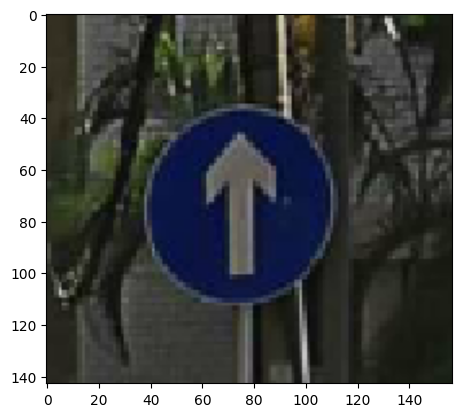

Predicted class: Don't go right or left


In [21]:
label = {0:"Speed Limit 5", 1:"Speed Limit 15", 2:"Speed Limit 30", 
         3:"Speed Limit 40", 4:"Speed Limit 50", 5:"Speed Limit 60", 
         6:"Speed Limit 70", 7:"Speed Limit 80", 8:"Don't go straight or left", 
         9:"Don't go straight or right", 10:"Don't go straight", 11:"No Left",
         12:"Don't go right or left", 13:"Don't go right", 14:"No Overtake from Left", 
         15:"No U-turn", 16:"No Cars", 17:"No Horn", 18:"Speed Limit (40km/h)",
         19:"Speed Limit (50km/h)", 20:"Go straight or right", 21:"Watch out for cars",
         22:"Go left", 23:"Go left or right", 24:"Go right", 25:"Keep Left",
         26:"Keep Right", 27:"Roundabout mandatory", 28:"Go Straight",
         29:"Horn", 30:"Bicycle Crossing", 31:"U-turn", 32:"Road Divider",
         33:"Traffic Signals", 34:"Danger ahead", 35:"Zebra Crossing",
         36:"Bicycle Crossing", 37:"Children Crossing", 38:"Dangerous curve to the left",
         39:"Dangerous curve to the right", 40:"Unknown 1", 41:"Unknown 2", 42:"Unknown 3",
         43:"Go right or straight", 44:"Go left or straight", 45:"Unknown 4", 
         46:"Zigzag curve", 47:"Train Crossing", 48:"Under construction", 49:"Unknown 5",
         50:"Fences", 51:"Heavy Vehicle Accidents", 52:"Unknown 6", 53:"Give way",
         54:"No Stopping", 55:"No Entry", 56:"Yield", 57:"Unknown 8"}

img_directory = "/kaggle/input/traffic-sign-dataset-classification/traffic_Data/TEST/021_1_0008.png"
test_image = image.load_img(img_directory, target_size=(128, 128))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image

result = model3.predict(test_image)
    
img = mpimg.imread(img_directory)
imgplot = plt.imshow(img)
plt.show()
    
print(f"Predicted class: {label[np.argmax(result)]}")

As you can see, the predicticted class matches what the image is saying showing that our model works well!

## Conclusion
Through this investigation, I feel that we were able to be pretty successful in my goal. I found a model using a pretrained one that was able to fairly accurately predict and determine common traffic signs.

However, I think the data I used was quite standardised, so I'm not sure if this accuracy would be the same for photos where there is more background noise or it is further away. A major challenge was trying to make sure that the model was not overfit to the data as certain classes did not have many images and some images were in mutiple classes as well. 

Nonetheless, I think this model is very applicable to the real world with further steps. It can be used for automation in transport or to help the visually impaired with road safety.

## Future Work
What are the next steps?

1. Having live image detection so cars can respond in real time
2. Converting it to speech for audio aid
3. Adding a wider variety of road signs / altering based on country

## References
1. Transfer learning example notebook (goes with the video demonstration)- https://www.kaggle.com/dansbecker/transfer-learning/
2. Kaggle Computer Vision course final notebook on Data Augmentation- https://www.kaggle.com/ryanholbrook/data-augmentation
3. Traffic Sign Dataset
https://www.kaggle.com/datasets/ahemateja19bec1025/traffic-sign-dataset-classification